# COMP0188 Coursework 2: Age Regression from Brain MRIs (30 Marks)

MRI scans can be used to determine volumes of different types of brain tissue which are associated with age. In particular, as patients age, it is known that the ventricles enlarge (as they get filled with cerebrospinal fluid), while the volume of grey and white matter volume may decrease.

Your task is to develop a deep learning model capable of predicting the (biological) age of a patient from MRI scans. Such a tool could be used in clinical practice to compare a patients 'biological' age against their 'true' chronological age. A significant discrepency in these ages might indicate the presense of a disease in the patient.

You have been provided with a dataset of healthy patients. The dataset contains MRI scans of the patients, and their corresponing chronological ages (amongst other information). As the patients are healthy, we will assume that their biological and chronological ages are equal.

We have provided you with helper code, and have marked additional code you will need to implement with "🚧 **Exercise** 🚧". However, you are not bound to this code (i.e. you may modify it if you wish), or even this notebook - you may complete the coursework however you see fit.

#### Notebook Overview
The notebook is split into 3 parts:

- Part 1: Dataset analysis and defining a suitable setup (8 marks)
- Part 2: Baseline model definition (7 marks)
- Part 3: Improving upon the Baseline (15 marks)

Please see the introduction for each section for more information.

#### Loading the Dataset and Running the Notebook

Use Google Colab to run the notebook. Run the cells in sequence, as per usual.

### Requirements
* SimpleITK
* wandb # not used

### Dependancies

In [1]:
!pip install SimpleITK gdown wandb

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import wandb

from typing import List, Dict, Tuple, Literal
import pickle
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

import gdown
import zipfile
import os
import psutil

In [4]:
### MY IMPORTS
import random
import pdb

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def check_memory_used():
    process = os.getpid()
    proc = psutil.Process(process)
    memory_info = proc.memory_info()
    print(f"Memory Used: {memory_info.rss / (1024**3):.2f} GB")  # RSS (Resident Set Size)
check_memory_used()

Memory Used: 0.54 GB


In [7]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

### Global config

In [8]:
google_colab=False
extract = False
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
   
    if extract:
      with zipfile.ZipFile('/content/drive/MyDrive/dataset_mri/coursework_1_compressed.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/dataset_mri/')
# !gdown --id download_url -O 'dataset_mri'
# !cp source_path destination_path
# 

In [55]:
# Used for debugging the notebook locally. Leave as True when running in colab!
download = False

# Expect the download to take roughly 3 mins
if download:
    # Replace this with your Google Drive shared link or file ID
    google_drive_shared_link = 'https://drive.google.com/file/d/1jjH9TeCprWOvIsFR5Aa7V6X_gX0GHRIA/view?usp=drivesdk'
    file_id = google_drive_shared_link.split('/')[-2]

    # Construct the gdown URL
    download_url = f'https://drive.google.com/uc?id={file_id}'

    # Path where the downloaded file will be stored
    output_path = 'download.zip'

    # Download the file from Google Drive
    gdown.download(download_url, output_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall('data')

    # Optionally, delete the zip file after extraction
    # os.remove(output_path)

    data_dir = "data/coursework_1_compressed/coursework_1"
else:
    data_dir = "/content/drive/MyDrive/dataset_mri/coursework_1_compressed/coursework_1" # data_dir = "../../coursework_1_compressed/coursework_1" # "../../coursework_1/coursework_1"
    data_dir = '/kaggle/input/cwk1-compressed/coursework_1_compressed/coursework_1'

Downloading...
From (uriginal): https://drive.google.com/uc?id=1jjH9TeCprWOvIsFR5Aa7V6X_gX0GHRIA
From (redirected): https://drive.google.com/uc?id=1jjH9TeCprWOvIsFR5Aa7V6X_gX0GHRIA&confirm=t&uuid=8ce09cf1-db5d-4129-b545-be5d2c4bc2ca
To: /kaggle/working/download.zip
100%|██████████| 4.92G/4.92G [00:38<00:00, 129MB/s] 


In [45]:
# os.remove(output_path)

In [56]:
MRI_TEMPLATE_FILE = os.path.join(data_dir, "quasiraw_space-MNI152_desc-brain_T1w.nii.gz")

In [57]:
TRAIN_DIR = os.path.join(data_dir, "train")
TRAIN_MRI_DIR = os.path.join(TRAIN_DIR, "quasiraw")
TRAIN_META_FILE = os.path.join(TRAIN_DIR, "participants.tsv")

In [58]:
TEST_DIR = os.path.join(data_dir, "test")
TEST_MRI_DIR = os.path.join(TEST_DIR, "quasiraw")
TEST_META_FILE = os.path.join(TEST_DIR, "participants.tsv")

In [59]:
OUT_SPACING = [2, 2, 2]
OUT_SIZE = [96, 96, 96]

## Part 1: Dataset analysis and define a suitable setup

### Dataset analysis

It is important to analyse your dataset to better understand it and to help detect any issues in the dataset. This can be done via visualizations and calculating statistics from the available information.

### Defining a suitable seup

Before performing any kind of model development, it is critical to define the scope of the model development process. This includes making decisions which stay fixed throughout the rest of the model development; as changing them would render model comparisons invalid. For example, comparing two models with test score calculated on different test datasets or with different metrics is meaningless.

This section should help you answer following questions:
* How should the train/validation/test set be split?
  - it should be split prior to dataset visualization to avoid test-set leakage. Also, I'll go for a random 75/15/15 ratio. It'd be seeded to ensure replicatibility.
* What metric will be used to assess model performance on the test set?
    * It is critical to consider the broader project metric when setting this. In this case the project metric is to "predict the patients biological age from MRI scans". Furthermore, we want to make sure that the model can predict age well for _all_ patients, not just a subset (which may happen if the input data is skewed, for example).
    * I consider using Mean Absolute Error given prior [work](https://www.nature.com/articles/s41467-019-13163-9)
      - data skewness makes mean-squared error a bit more robust to large errors. Though MAE is robust to outliers.
      - if I factor in model complexity and dataset size, can use adjusted $R^2$
      - use **multiple metrics**

_Hint_:
* Consider the following kinds of analysis:
    * What relevant variables are available in the dataset? Do they need to be transformed?
    * What does the target variable look like?
    * Is the data sufficiently balanced?
    * What is the distribution of other variables?

### Dataset description
* The data provided has already been split into a training and test dataset. Both the training and test data contain: (i) a file of images in the form of numpy arrays (the MRIs); (ii) a tab seperated file called "participants.tsv" which contains structured data for each patient (including the overall target of interest "age").
* The "participant_id" column defines a unique ID for each patient and can be used to link the structured data with the MRI scans. In particular, the patient with participant_id = "100053248969" has an associated MRI scan in the file "sub-100053248969_preproc-quasiraw_T1w.npy"

The code below provides some helper functions for to import the relevant data for analysis

In [60]:
num_vars = ["age", "tiv", "csfv", "gmv", "wmv", "magnetic_field_strength", "acquisition_setting"]

# Load the training data
train_meta_df = pd.read_csv(TRAIN_META_FILE, delimiter='\t', dtype=str)
train_meta_df[num_vars] = train_meta_df[num_vars].astype(float)
train_meta_df["age_round"] = np.round(train_meta_df["age"],0).astype(int)
print(train_meta_df.shape)

bins = list(range(0, 80, 10))
bins.append(110)
train_meta_df["age_10_yr_bckt_bg_70"] = pd.cut(train_meta_df["age"], bins=bins)
print(train_meta_df["age_10_yr_bckt_bg_70"].value_counts())
train_meta_df["age_10_yr_bckt"] = pd.cut(train_meta_df["age"], bins=range(0, 110, 10))
print(train_meta_df["age_10_yr_bckt"].value_counts())

# Also load the test data - BUT DON'T LOOK AT IT!
test_meta_df = pd.read_csv(TEST_META_FILE, delimiter='\t', dtype=str)
test_meta_df[num_vars] = test_meta_df[num_vars].astype(float)
test_meta_df["age_round"] = np.round(train_meta_df["age"],0).astype(int)
print(test_meta_df.shape)

test_meta_df["age_10_yr_bckt_bg_70"] = pd.cut(test_meta_df["age"], bins=bins)
print(test_meta_df["age_10_yr_bckt_bg_70"].value_counts())
test_meta_df["age_10_yr_bckt"] = pd.cut(test_meta_df["age"], bins=range(0, 110, 10))
print(test_meta_df["age_10_yr_bckt"].value_counts())

train_meta_df.head()

(466, 13)
age_10_yr_bckt_bg_70
(20, 30]     220
(10, 20]     152
(30, 40]      24
(0, 10]       21
(60, 70]      18
(40, 50]      14
(50, 60]       9
(70, 110]      8
Name: count, dtype: int64
age_10_yr_bckt
(20, 30]     220
(10, 20]     152
(30, 40]      24
(0, 10]       21
(60, 70]      18
(40, 50]      14
(50, 60]       9
(70, 80]       8
(80, 90]       0
(90, 100]      0
Name: count, dtype: int64
(167, 14)
age_10_yr_bckt_bg_70
(20, 30]     84
(10, 20]     53
(0, 10]      10
(30, 40]      9
(40, 50]      4
(60, 70]      4
(50, 60]      2
(70, 110]     1
Name: count, dtype: int64
age_10_yr_bckt
(20, 30]     84
(10, 20]     53
(0, 10]      10
(30, 40]      9
(40, 50]      4
(60, 70]      4
(50, 60]      2
(70, 80]      1
(80, 90]      0
(90, 100]     0
Name: count, dtype: int64


,participant_id,study,sex,age,site,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,age_round,age_10_yr_bckt_bg_70,age_10_yr_bckt
0,100053248969,8,female,19.0,48.0,control,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,19,"(10, 20]","(10, 20]"
1,100263562592,4,male,21.0,3.0,control,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,21,"(20, 30]","(20, 30]"
2,100479214233,2,female,21.0,29.0,control,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,21,"(20, 30]","(20, 30]"
3,100544064116,3,female,15.0,65.0,control,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,15,"(10, 20]","(10, 20]"
4,101404752059,4,male,31.0,3.0,control,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,31,"(30, 40]","(30, 40]"


Descriptions for relevant (non-self-descriptive) column names:
- **participant_id:** Unique ID for each patient, can be used to link to the MRI scans.
- **csfv:** Cerebrospinalfluid volume
- **gmv:** Grey matter volume
- **wmv:** White matter volume


In [61]:
def load_patient_mri_array(
    patient_id:str,
    mri_dir:str
    ) -> np.array:
    """Function to load a patient .nii.gz file containing an MRI 3D scan into a
    numpy array

    Args:
        patient_id (str): Patient ID string
        mri_dir (str): String representing the directory containing the MRI
        .nii.gz files

    Returns:
        np.array: 3D numpy array representing the MRI scan
    """
    mri_file = f"nifti/sub-{patient_id}_preproc-quasiraw_T1w.nii.gz"
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(mri_dir, mri_file)))
    return np.expand_dims(img_array, axis=0)

def vis_raw_mri_image(
    img_array:np.array,
    x:int=None,
    y:int=None,
    z:int=None,
    crosshair:bool=False,
    template_file:str=MRI_TEMPLATE_FILE
):
    """Function to display orthogonal 2D slices of the 3D MRI image

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan
        x (int, optional): x slice co-ordinate. Defaults to None.
        y (int, optional): y slice co-ordinate. Defaults to None.
        z (int, optional): z slice co-ordinate. Defaults to None.
        crosshair (bool, optional): Flag that determines whether the images
        should be shown with x/y lines across the centres of the axes.
        Defaults to False.
        template_file (str, optional): String representing the MRI template file
        to extract the image dimensions. Defaults to MRI_TEMPLATE_FILE.
    """
    template = sitk.ReadImage(template_file)
    size = template.GetSize()
    spacing = template.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]

    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()

Let's use the helper functions above to visualise the MRI scans for patient "100053248969"

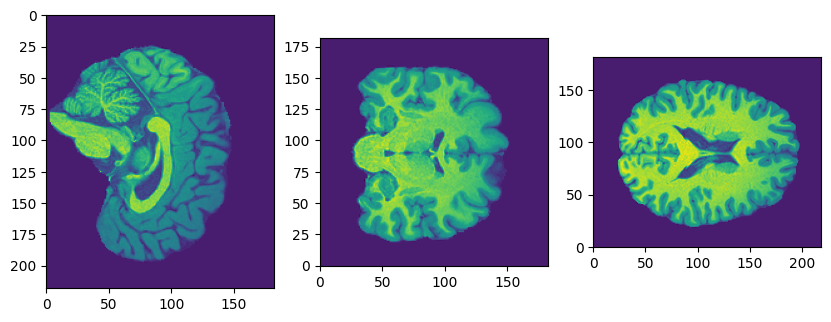

(1, 182, 218, 182)

In [62]:
img_array = load_patient_mri_array("100053248969", mri_dir=TRAIN_MRI_DIR)
vis_raw_mri_image(img_array.squeeze())
display(img_array.shape)

🚧 **Exercise 1.1** 🚧

Below, perform any data analysis / data visualizations you think will be useful. These may help you better understand the distribution and demographics of the dataset.


In [65]:
####################
# Insert code here #
####################
from sklearn.model_selection import train_test_split
### train-test ratio
print('train-test ratio: ', len(train_meta_df)/(len(train_meta_df) + len(test_meta_df)))
my_train_df, my_val_df = train_test_split(train_meta_df, test_size=0.15)
### train-val split
print('train-test ratio: 0.85/0.15')


train-test ratio:  0.7361769352290679
train-test ratio: 0.85/0.15


In [66]:
### NA Values
sum(my_train_df.isna().sum())

0

In [67]:
### Checking categories with single instances that don't appear in validation split
CAT_VARS = ['study', 'sex', 'diagnosis', 'age_10_yr_bckt_bg_70', 'age_10_yr_bckt']
for cat in CAT_VARS:
  print(cat)
  print("number of unique values in training split: ", my_train_df[cat].nunique())
  print("number of unique values in validation split: ", my_val_df[cat].nunique())


study
number of unique values in training split:  10
number of unique values in validation split:  9
sex
number of unique values in training split:  2
number of unique values in validation split:  2
diagnosis
number of unique values in training split:  1
number of unique values in validation split:  1
age_10_yr_bckt_bg_70
number of unique values in training split:  8
number of unique values in validation split:  7
age_10_yr_bckt
number of unique values in training split:  8
number of unique values in validation split:  7


In [68]:
### CONVERT CATEGORIES TO NUMBERS
for col in my_train_df.columns:
    if col in CAT_VARS:
      my_train_df[col] = pd.factorize(my_train_df[col])[0]
    else:
      my_train_df[col] = pd.to_numeric(my_train_df[col])

In [70]:
### DROP IRRELEVANT COLUMNS
print(my_train_df['age_10_yr_bckt_bg_70'].equals(my_train_df['age_10_yr_bckt']))
my_train_df.drop(columns=['participant_id', 'age_round', 'age_10_yr_bckt_bg_70'], axis=1, inplace=True)

True


In [71]:
### SUMMARY STATS
my_train_df.describe().loc[['mean', 'std', 'min', 'max']]

,study,sex,age,site,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,age_10_yr_bckt
mean,4.270202,0.530303,24.619896,26.757576,0.0,1457.536764,252.652178,689.614967,514.414696,2.924242,1.242424,1.527778
std,2.173540,0.499712,12.679297,17.929590,0.0,150.386099,57.106410,88.433299,65.445793,0.328893,0.543610,1.853286
min,0.000000,0.000000,6.685832,2.000000,0.0,1110.237080,139.269620,348.670812,366.674730,1.500000,1.000000,0.000000
max,9.000000,1.000000,78.203970,70.000000,0.0,1883.621349,488.987090,910.051941,724.556025,3.000000,3.000000,7.000000


In [72]:
### SCALING
from sklearn.preprocessing import MinMaxScaler

SCALE_CONT_VARIABLES = ['tiv', 'csfv', 'gmv', 'wmv'] # maybe 'age', though I don't want to make interpretation difficult

def min_max_scale(df, colums):
  scaler = MinMaxScaler()
  df[colums] = scaler.fit_transform(df[colums])
  return df

scaled_my_train_df = min_max_scale(my_train_df,SCALE_CONT_VARIABLES)

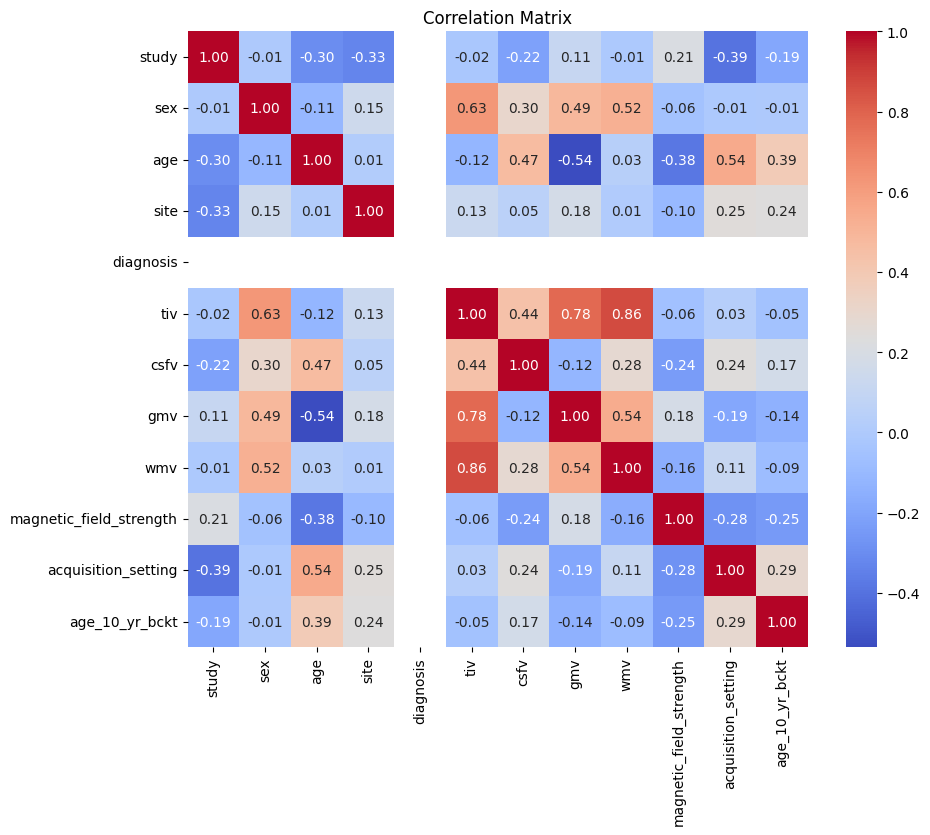

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
### PLOT CORRELATION MATRIX
corr_matrix = scaled_my_train_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

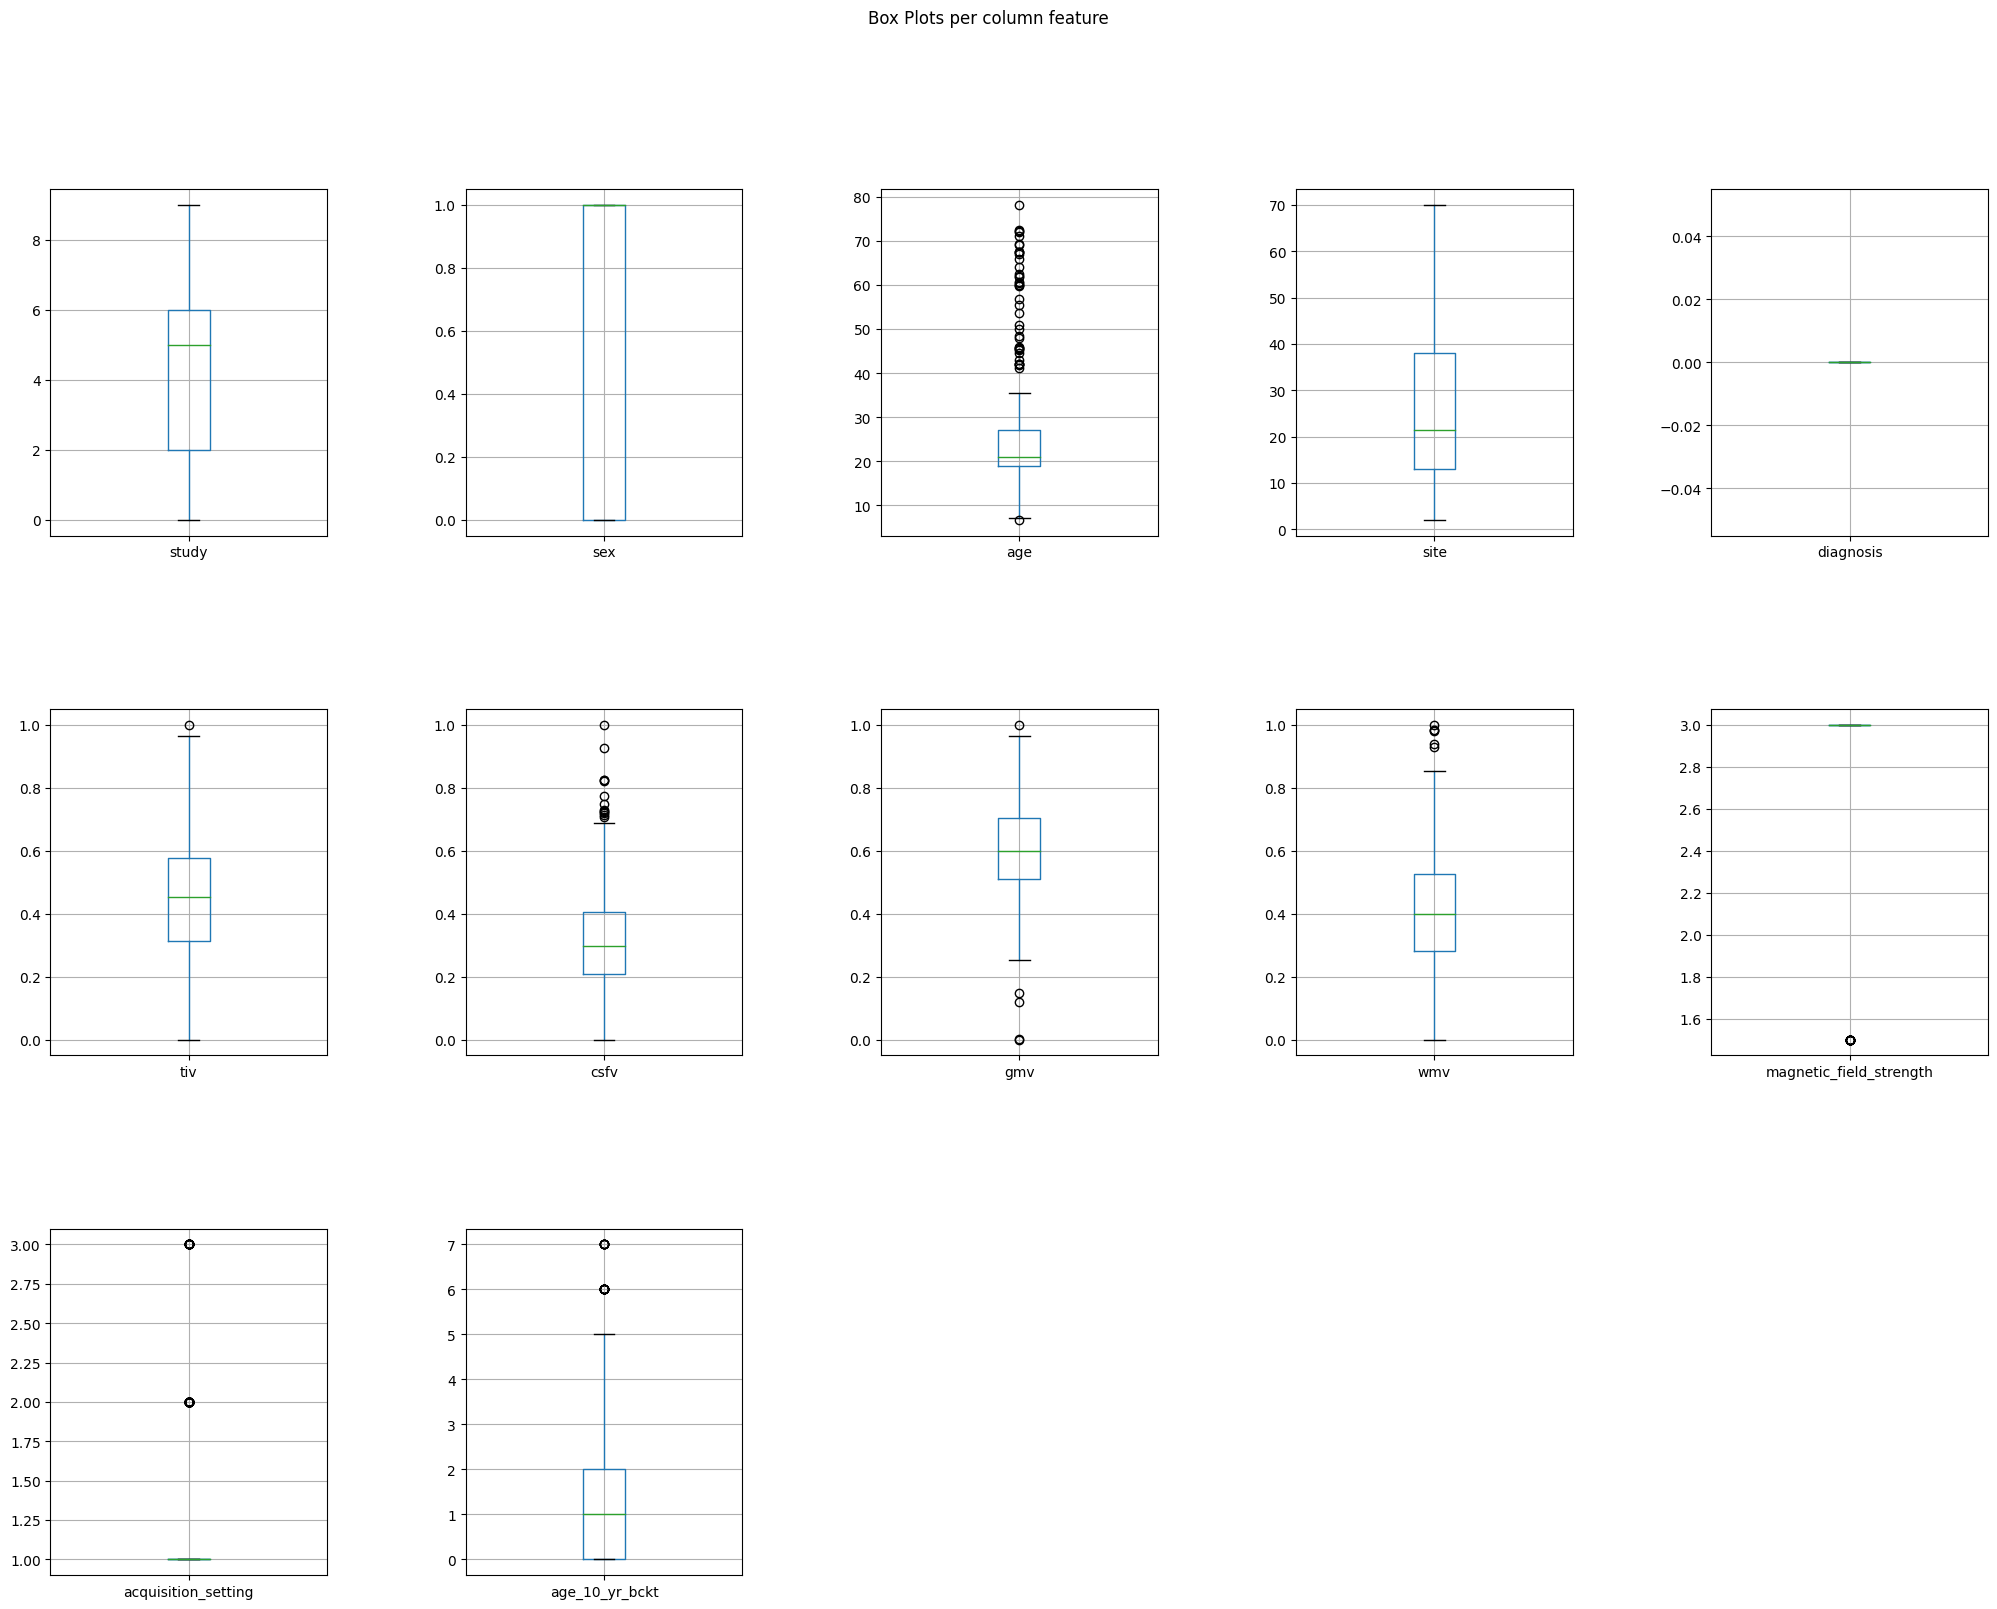

In [74]:
### PLOT BOXPLOTS
gs = plt.GridSpec(3, 5)

# create a list of subplots
axs = [plt.subplot(gs[i]) for i in range(scaled_my_train_df.shape[1])]

# create boxplots for each column
for i, column in enumerate(scaled_my_train_df.columns):
    scaled_my_train_df[[column]].boxplot(ax=axs[i], vert=True)
    # axs[i].set_title(column)

# customize the plot as desired
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle('Box Plots per column feature')

fig = plt.gcf()
fig.set_size_inches(25, 18)

# show the resulting plot
plt.show()

In [75]:
train_meta_df[['age', 'age_round']]
train_meta_df.dtypes
train_meta_df.head(5)
my_train_df.describe().loc[['min', 'max', 'mean', 'std']]
# train_meta_df.columns

,study,sex,age,site,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,age_10_yr_bckt
min,0.000000,0.000000,6.685832,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000,0.000000
max,9.000000,1.000000,78.203970,70.000000,0.0,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,7.000000
mean,4.270202,0.530303,24.619896,26.757576,0.0,0.449065,0.324212,0.607331,0.412818,2.924242,1.242424,1.527778
std,2.173540,0.499712,12.679297,17.929590,0.0,0.194452,0.163293,0.157528,0.182870,0.328893,0.543610,1.853286


🚧 **Exercise 1.2** 🚧

In the code block below, add:
* ```train_prop```: The proportion of the train data that you will assign to training the model (where the remaining will be used for validation)
* ```stratification_variables```: Whether you intend to stratify by any variables when creating the train/validation split
* ```test_metric```: The metric you intend to use to assess performance on the test set

(Stratified sampling is a technique used to ensure that the subsets of the data (in this case, training, validation, and test sets) are representative of the whole dataset. This is especially important in cases where the dataset is not homogeneous and contains distinct groups that should be evenly represented in each set.)

In [77]:
# Exercise: input answer here
# Your code here
train_prop = 0.85
stratification_variables = ['age_10_yr_bckt'] # a list of variables from the meta data, e.g. ["variable_1", "variable_2"]. Ensure you choose at least one variable, or the code will not run!
test_metric = F.l1_loss # This is not used later in the notebook, but it is good to decide it now
# Your code here - END

The code below defines three numpy arrays ```train_pats```, ```val_pats``` and ```test_pats``` containing a (potentially stratified) random selection of patient ids assigned to the respective datasets.

In [78]:
grp_df = train_meta_df.groupby(by=stratification_variables)
train_pats = []
val_pats = []
test_pats = []
for idx, grp in grp_df:
    train, val = np.split(
        grp["participant_id"],
        [
            int(np.floor(grp.shape[0]*train_prop))
        ]
    )
    train_pats.append(train)
    val_pats.append(val)
train_pats = np.concatenate(train_pats)
val_pats = np.concatenate(val_pats)
test_pats = test_meta_df["participant_id"].values

with open(os.path.join(TRAIN_DIR, "train_pats.pkl"), "wb") as f:
    pickle.dump(train_pats, f)

with open(os.path.join(TRAIN_DIR, "val_pats.pkl"), "wb") as f:
    pickle.dump(val_pats, f)

with open(os.path.join(TEST_DIR, "test_pats.pkl"), "wb") as f:
    pickle.dump(test_pats, f)

print(f"Num training patients: {len(train_pats)}")
print(f"Num validation patients: {len(val_pats)}")
print(f"Num testing patients: {len(test_pats)}")

Num training patients: 392
Num validation patients: 74
Num testing patients: 167


/tmp/ipykernel_43/781461976.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_df = train_meta_df.groupby(by=stratification_variables)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


## Part 2: Baseline model definition

Now the model development assumptions have been defined, a baseline model needs to be developed. This baseline model should act as a spring board for your subsequent model development. Ideally should balance the following objectives:
* Attain a __reasonable__ level of performance, and;
* Be __simple__! This is almost the most important requirement since if the model is too complex, understanding which areas of the archtecture are underperforming will be challenging!


In this exercise the baseline model should be defined by the following pipeline:

1. **Volume prediction:** A deep learning model is trained to take in patient MRI images and predict three patient brain volume values (explained in more detail below).
2. **MLP Regression:** A multi-layer perceptron regression model takes patient brain volume values as input and predicts patient age.

These models will be trained seperately, then combined to make end-to-end MRI -> age predictions at test time. We elaborate more on the motivation behind this pipeline below.

__Your main task__ will be to define the deep learning Volume Prediction model and subsequently justify and explain your design choices.

_Hints_:
* What might be a 'simple' go-to deep learning architecture for processing images?
A simple 3D convolutional neural network. Implementation is provided by prompting perplexity.ai

* Do 3D images need to be treated differently to 2D images (see Pytorch [CONV3D](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html#conv3d)...)
Implementation-wise yes. 

* How might 'reasonable' be defined?
    * Does the baseline perform better than random chance?
    
    Maybe, though I won't check this manually nor is this done in the literature. A baseline is simply the first implementation that yields some results. 
    * Does the baseline perform better than just applying a linear regression or xgBoost model directly on the images?
    
    It could be a good test, though I don't do this since it isn't necessary. I just define a simple 3D CNN as a starting point
* As this is a baseline, performance is not expected to be excellent. As you are only expected to implement the volume predictor, it is ok if other parts of the pipline are limiting. However, you may make small modifications to the mlp training, etc. to ensure reasonable performance.

### Data Helpers

Before we begin, lets load and process the data.

In [80]:
def zero_mean_unit_var(
    img_array:np.array
    )->np.array:
    """Function to normalise an input image to have 0 mean and unit variance

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan

    Returns:
        np.array: Normalised version of img_array
    """
    mean = np.mean(img_array)
    std = np.std(img_array)
    # Capture 0 values as these are background
    zero_values = img_array == 0
    if std > 0:
        img_array = (img_array - mean) / std
        img_array[zero_values] = 0
    return img_array


def resample_image(
    img_array:np.array,
    out_spacing:Tuple[float]=(1.0, 1.0, 1.0),
    out_size:Tuple[float]=None,
    is_label:bool=False,
    pad_value=0
    )->np.array:
    """Function to alter the proportions of an input image represented as a
    numpy array

    Args:
        img_array (np.array): 3D numpy array representing the MRI scan
        out_spacing (Tuple[float], optional): ???. Defaults to (1.0, 1.0, 1.0).
        out_size (Tuple[float], optional): Tuple of length 3 defining the
        desired output dimensions of the image. Defaults to None.
        is_label (bool, optional): ???. Defaults to False.
        pad_value (int, optional): ???. Defaults to 0.

    Returns:
        np.array: _description_
    """

    image = sitk.GetImageFromArray(img_array)
    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return sitk.GetArrayFromImage(resample.Execute(image))

We will create seperate dataloaders for the volume prediction task and the linear regression task.

First, we create the volume prediction data loaders. This data loader provides a batch of 3D MRI images as 'X', and the corresponding brain volume labels as 'y'. The train/val/test splits you decided previously will be used.

In [81]:
class VolumePredictionDataset(Dataset):
    '''
    Important: By default, this dataset returns normalized versions of the input MRI images and output volume labels.
    '''

    def __init__(
        self,
        patient_list:List[str],
        mri_file_dir:str,
        meta_df:pd.DataFrame,
        volume_norm_stats:Dict[str,np.array],
        out_spacing = OUT_SPACING,
        out_size = OUT_SIZE,
    ):
        self.samples:List[Dict[str,torch.tensor]] = []

        for pat in tqdm(patient_list, desc='Loading Data'):

            # MRI image
            X = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X = zero_mean_unit_var(X)
            if (out_spacing is not None) and (out_size is not None):
                X = resample_image(X, out_spacing=out_spacing, out_size=out_size)
            X = torch.from_numpy(X).unsqueeze(0).float()

            # Volume labels
            y = meta_df[meta_df["participant_id"] == pat][["csfv", "gmv", "wmv"]].values.squeeze()
            y = (y-volume_norm_stats['mean'])/volume_norm_stats['std']
            y = torch.from_numpy(y).float()

            sample = {'X': X,  "y":y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

**Data normalization:**

In our datasets, we will normalize both the input and the output data for model training. Images are simply normalized to each have zero mean and unit variance. Volumes and ages are normalized using statistics of the train dataset, calculated below.

In [82]:
# Normalization stats

age_norm_stats = {
    'mean': train_meta_df["age"].mean(axis=0),
    'std': train_meta_df["age"].std(axis=0)
}

volume_norm_stats = {
    'mean': train_meta_df[["csfv", "gmv", "wmv"]].mean(axis=0).values,
    'std': train_meta_df[["csfv", "gmv", "wmv"]].std(axis=0).values
}

display(age_norm_stats)
display(volume_norm_stats)

{'mean': 24.730252048494517, 'std': 13.336105435557256}

{'mean': array([253.44248979, 688.5824933 , 513.71863709]),
 'std': array([58.58350478, 88.89055568, 65.53866211])}

In [83]:
# Expect this cell to take 8 mins

batch_size = 8 # Can be changed if you wish

vol_train_data = VolumePredictionDataset(
    patient_list=train_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)

vol_train_loader = DataLoader(vol_train_data, batch_size=batch_size)

vol_val_data = VolumePredictionDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
)

vol_val_loader = DataLoader(vol_val_data, batch_size=batch_size)

vol_test_data = VolumePredictionDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df,
    volume_norm_stats=volume_norm_stats,
)

tmp = next(vol_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (MRI images) dimensions are: {tmp['X'].shape}")
print(f"The output (csfv, gmv, wmv brain volumes) dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 167/167 [02:09<00:00,  1.29it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (MRI images) dimensions are: torch.Size([8, 1, 96, 96, 96])
The output (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([8, 3])


Ensure you understand what the inputs and outputs represent, and what each axis of the data represents.

Next, we define the data loaders for the MLP age regression task. These return brain volumes as 'X' and age labels as 'y'.

In [91]:
class AgeRegressionDataset(Dataset):
    '''
    Important:
    - By default, this dataset returns normalized versions of the input volumes and output age labels.
    '''

    def __init__(
        self,
        patient_list:List[str],
        meta_df:pd.DataFrame,
        volume_norm_stats:Dict[str,np.array],
        age_norm_stats:Dict[str,np.array],
    ):
        self.samples:List[Dict[str,torch.tensor]] = []

        for pat in tqdm(patient_list, desc='Loading Data'):

            # Brain volumes
            X = meta_df[meta_df["participant_id"] == pat][["csfv", "gmv", "wmv"]].values.squeeze()
            X = (X-volume_norm_stats['mean'])/volume_norm_stats['std']
            X = torch.from_numpy(X).float()

            # Ages
            y = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y = (y-age_norm_stats['mean'])/age_norm_stats['std']
            y = torch.tensor(y).float()

            sample = {'X': X,  "y":y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

In [92]:
rnd_seed = 42
batch_size = 2

mlp_train_data = AgeRegressionDataset(
    patient_list=train_pats,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
    age_norm_stats=age_norm_stats,
)
mlp_train_loader = DataLoader(mlp_train_data, batch_size=batch_size)

mlp_val_data = AgeRegressionDataset(
    patient_list=val_pats,
    meta_df=train_meta_df,
    volume_norm_stats=volume_norm_stats,
    age_norm_stats=age_norm_stats,
)
mlp_val_loader = DataLoader(mlp_val_data, batch_size=batch_size)

tmp = next(mlp_train_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input (csfv, gmv, wmv brain volumes) dimensions are: {tmp['X'].shape}")
print(f"The output (patient age) dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 74/74 [00:00<00:00, 412.92it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input (csfv, gmv, wmv brain volumes) dimensions are: torch.Size([2, 3])
The output (patient age) dimensions are: torch.Size([2])


Again, ensure you understand what the inputs and outputs represent, and what each axis of the data represents.

### Motivating the baseline model pipeline

Our training dataset provides ground-truth information about patient brain volumes, namely:
- csfv: Cerebrospinal fluid volume
- gmv: Grey matter volume
- wmv: White matter volume

It has been found previously that these brain volumes are correlated with age. Lets investigate if that is the case in our dataset. If so, these values could be useful for our task of predicting brain age!


In [93]:
# Get ages
ages = train_meta_df["age"].values

# Get volumes
volumes = train_meta_df[["csfv", "gmv", "wmv"]].values
csfv = volumes[:,0]
gmv = volumes[:,1]
wmv = volumes[:,2]

In [94]:
volumes.shape

(466, 3)

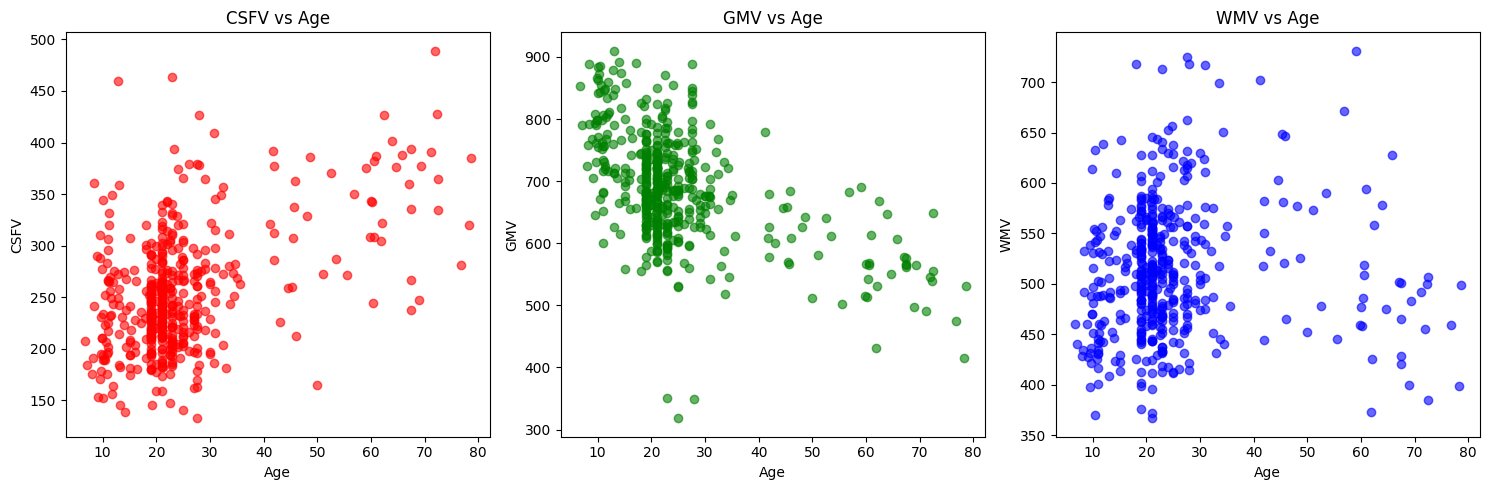

In [95]:
# Create scatter plots to visualize the correlation between volumes and age

import matplotlib.pyplot as plt

# Create a figure and a 1x3 subplot (for 3 plots in a row)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot csfv vs age
axes[0].scatter(ages, csfv, color='r', alpha=0.6)
axes[0].set_title('CSFV vs Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('CSFV')

# Plot gmv vs age
axes[1].scatter(ages, gmv, color='g', alpha=0.6)
axes[1].set_title('GMV vs Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('GMV')

# Plot wmv vs age
axes[2].scatter(ages, wmv, color='b', alpha=0.6)
axes[2].set_title('WMV vs Age')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('WMV')

# Display the plots
plt.tight_layout()
plt.show()

We see some visual evidence here that age is correlated with the brain volumes. This means the brain volume information may be useful for predicting age.

Thus, we may be able to split our baseline model into two parts: (i) Volume Prediction Model: a deep learning model that predicts brain volumes from MRI images; and (ii) MLP Regression Model: a multi-layer perceptron regression model that predicts age from brain volumes.

Note, this approach leverages the brain volume information available to in the training data, but will not require any ground-truth brain volume information at deplyoment! (At training, the Linear Regression Model will be trained to map from ground-truth volumes to age. But at deployment it will take volume values predicted by the Volume Prediction Model).

### Baseline: MLP Regression training

First lets train the MLP regression model.

Lets define some standard training and testing functions.

(**Optional Exercise**: You may modify these training and testing functions if you wish to add more sophisticated logging)

In [96]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()

    total_loss = 0
    for step, data in enumerate(dataloader):
        X, y = data['X'].to(device), data['y'].to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # pdb.set_trace()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / num_batches
    print(f"Train loss: {average_loss:9f}")
    return average_loss


In [97]:
def test(dataloader, model, loss_fn, y_norm_stats):
    def denorm(y):
        return y.cpu() * y_norm_stats['std'] + y_norm_stats['mean']

    num_batches = len(dataloader)
    model.eval()

    test_loss, mae_loss = 0, 0
    with torch.no_grad():
        for data in dataloader:
            X, y = data['X'].to(device), data['y'].to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            mae_loss += torch.mean(torch.abs(denorm(pred) - denorm(y))).item()

    test_loss /= num_batches
    mae_loss /= num_batches
    print(f"Validation loss: {test_loss:9f}, MAE: {mae_loss:9f}\n")
    return test_loss, mae_loss



Now define the linear regression model in pytorch.

In [101]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPRegression, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

tmp = next(mlp_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]

mlp_model = MLPRegression(in_shape[0]).float().to(device)

output = mlp_model(tmp['X'].to(device))
print("MLP Regression Model output shape: ", output.shape)

MLP Regression Model output shape:  torch.Size([2, 1])


Now train the lmlp regression model

In [99]:
mlp_loss_fn = nn.MSELoss()
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)

In [100]:
epochs = 30
mlp_train_losses = []
mlp_val_losses = []
mlp_mae_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(mlp_train_loader, mlp_model, mlp_loss_fn, mlp_optimizer)
    val_loss, mae_loss = test(mlp_val_loader, mlp_model, mlp_loss_fn, age_norm_stats)
    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)
    mlp_mae_losses.append(mae_loss)
print("Done!")

Epoch 1
-------------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss:  0.397928
Validation loss:  1.238707, MAE: 12.804124

Epoch 2
-------------------------------
Train loss:  0.729179
Validation loss:  0.684221, MAE:  8.318389

Epoch 3
-------------------------------
Train loss:  0.568640
Validation loss:  0.637876, MAE:  7.744654

Epoch 4
-------------------------------
Train loss:  0.537591
Validation loss:  0.623497, MAE:  7.534799

Epoch 5
-------------------------------
Train loss:  0.518695
Validation loss:  0.619537, MAE:  7.431562

Epoch 6
-------------------------------
Train loss:  0.507451
Validation loss:  0.617750, MAE:  7.360646

Epoch 7
-------------------------------
Train loss:  0.499365
Validation loss:  0.616151, MAE:  7.299318

Epoch 8
-------------------------------
Train loss:  0.491866
Validation loss:  0.616390, MAE:  7.257068

Epoch 9
-------------------------------
Train loss:  0.486934
Validation loss:  0.614880, MAE:  7.211186

Epoch 10
-------------------------------
Train loss:  0.480824
Validation loss:  0.617

If all has gone well, you should see the loss decreasing on both the train and validation data

Lets check some predictions to visually inspect the models accuracy.

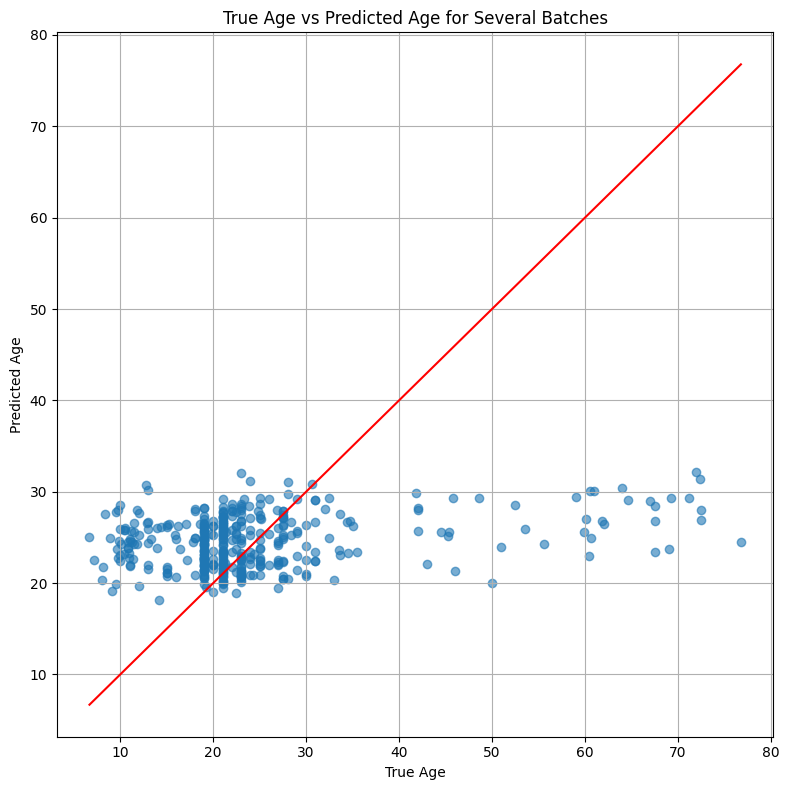

In [104]:
true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches (e.g., 10 batches in this example)
for i, batch in enumerate(mlp_train_loader):
    with torch.no_grad():
        inputs = batch['X'].to(device)
        true_ages = batch['y'].cpu().numpy().reshape(-1)
        predicted_ages = mlp_model(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# denormalize the true ages
true_ages_list = np.array(true_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']
predicted_ages_list = np.array(predicted_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']

plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title('True Age vs Predicted Age for Several Batches')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

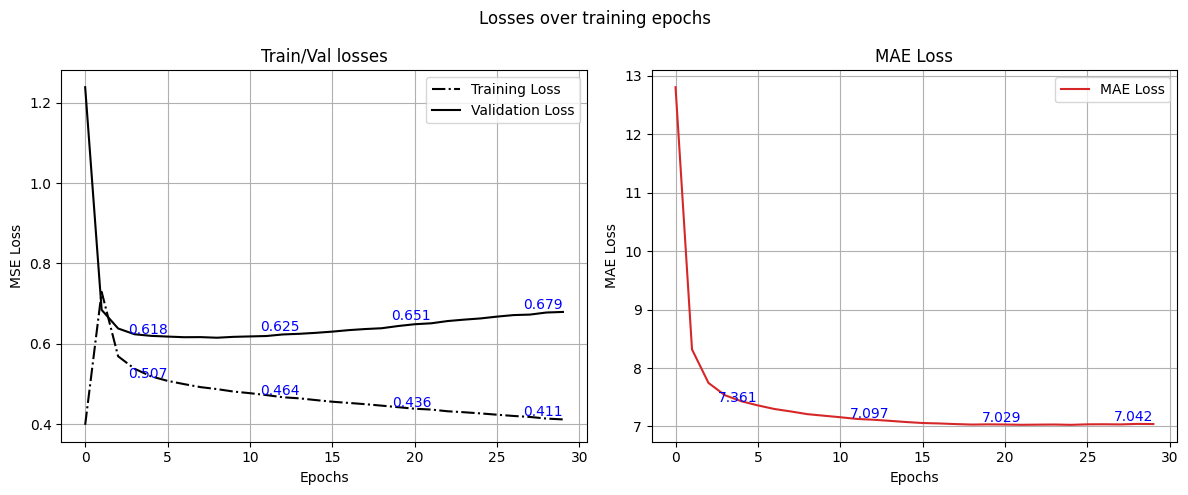

In [103]:
### Plotting Losses

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x_epochs = [i for i in range(epochs)]
ax1.plot(x_epochs, mlp_train_losses, 'k', label='Training Loss', linestyle='-.')
ax1.plot(x_epochs, mlp_val_losses, 'k', label='Validation Loss')
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Train/Val losses')
# ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y')
ax1.legend()
ax1.grid(True)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('MAE Loss')
ax2.plot(x_epochs, mlp_mae_losses, color=color, label="MAE Loss")
ax2.tick_params(axis='y')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_title('MAE Loss')
plt.xlabel('Epochs')
fig.suptitle('Losses over training epochs')
ax2.grid(True)


for i in range(5, epochs, 8):
    ax1.text(x_epochs[i], mlp_train_losses[i], f'{mlp_train_losses[i]:.3f}', ha='right', va='bottom', color='b')
    ax1.text(x_epochs[i], mlp_val_losses[i], f'{mlp_val_losses[i]:.3f}', ha='right', va='bottom', color='b')
    ax2.text(x_epochs[i], mlp_mae_losses[i], f'{mlp_mae_losses[i]:.3f}', ha='right', va='bottom', color='b')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Baseline: Deep Neural Network Brain Volume Prediction

Now you must define and train your volume prediction model!

🚧 **Exercise 2.1** 🚧

Define the volume prediction model.

In [110]:
# !pip install torchsummary

In [202]:
import torchvision.models as models
from torchsummary import summary


class VolumePredictor(nn.Module):
    def __init__(self, in_shape, out_size):
        super(VolumePredictor, self).__init__()
        ##################
        # Your code here #
        ##################
        self.in_shape = in_shape
        self.conv1 = nn.Conv3d(1, 2, kernel_size=3)
        self.fc1 = nn.Linear(2 * 47 *  47 * 47, out_size)# 3 output values: "csfv", "gmv", "wmv"
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(2)

    def forward(self, x):
        ##################
        # Your code here #
        ##################
        x = self.pool(self.relu(self.conv1(x)))
        # pdb.set_trace()
        x = torch.flatten(x, start_dim=1) # (B, 16 * 47 *  47 * 47)
        x = self.fc1(x)
        return x


In [113]:
# Define model and run a batch through the model to check it works
tmp = next(vol_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]

vol_model = VolumePredictor(in_shape, out_size).float().to(device)
input = tmp['X'].to(device)
output = vol_model(input)
print(output.shape)
summary(vol_model, (1, 96, 96, 96))

torch.Size([8, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 2, 94, 94, 94]              56
              ReLU-2        [-1, 2, 94, 94, 94]               0
         MaxPool3d-3        [-1, 2, 47, 47, 47]               0
            Linear-4                    [-1, 3]         622,941
Total params: 622,997
Trainable params: 622,997
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.38
Forward/backward pass size (MB): 26.93
Params size (MB): 2.38
Estimated Total Size (MB): 32.68
----------------------------------------------------------------


#### Train volume prediction model

**Optional Exercise:** Feel free to modify the training loop, training parameters, etc, if there is anything you wish to improve

In [203]:
vol_model = VolumePredictor(in_shape, out_size).float().to(device)
vol_loss_fn = nn.MSELoss()
vol_optimizer = torch.optim.Adam(vol_model.parameters(), lr=1e-3)

In [204]:
train_or_not = True
if train_or_not:
  epochs = 30
  train_losses = []
  val_losses = []
  val_mae_losses = []
  # early_stopping = EarlyStopping(patience=5, min_delta=0.1)
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss = train(vol_train_loader, vol_model, vol_loss_fn, vol_optimizer)
      val_loss, val_mae_loss = test(vol_val_loader, vol_model, vol_loss_fn, volume_norm_stats)
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_mae_losses.append(val_mae_loss)
  print("Done!")

Epoch 1
-------------------------------
Train loss: 17.916026
Validation loss:  1.650398, MAE: 70.164850

Epoch 2
-------------------------------
Train loss:  0.955621
Validation loss:  1.326718, MAE: 65.122141

Epoch 3
-------------------------------
Train loss:  0.707850
Validation loss:  1.221361, MAE: 61.963176

Epoch 4
-------------------------------
Train loss:  0.520545
Validation loss:  1.117275, MAE: 59.033408

Epoch 5
-------------------------------
Train loss:  0.393833
Validation loss:  1.056186, MAE: 57.116820

Epoch 6
-------------------------------
Train loss:  0.304449
Validation loss:  0.999810, MAE: 55.312458

Epoch 7
-------------------------------
Train loss:  0.238545
Validation loss:  0.949520, MAE: 53.606613

Epoch 8
-------------------------------
Train loss:  0.189489
Validation loss:  0.916908, MAE: 52.466693

Epoch 9
-------------------------------
Train loss:  0.152565
Validation loss:  0.893671, MAE: 51.866504

Epoch 10
-------------------------------
Train

In [205]:
save_model = False
if save_model:
  torch.save(vol_model.state_dict(),'baseline_3d_cnn_%d.pth' % epochs) # no need to rerun again

checkpoint_load = False
if checkpoint_load:
  checkpoint = torch.load('/content/drive/MyDrive/dataset_mri/baseline_3d_cnn_30.pth',
                          map_location=device)
  vol_model.load_state_dict(checkpoint)


Visualize the volume predictions:

TRAINING PERFORMANCE


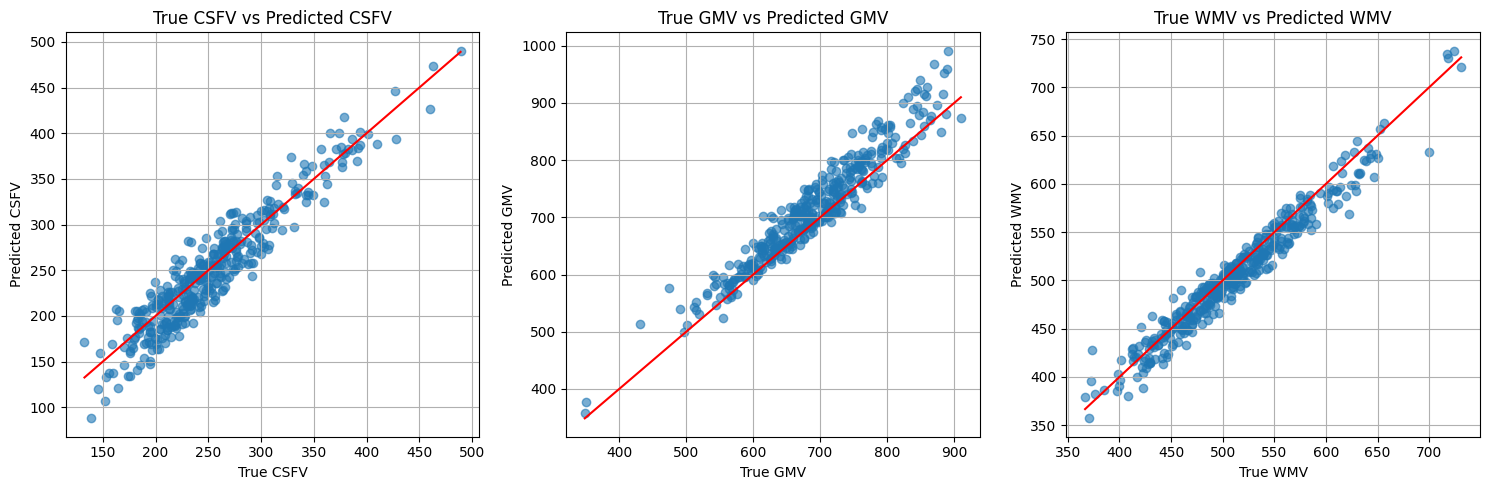

In [206]:
def visualize_preds(loader, model):

  true_csfv_list = []
  predicted_csfv_list = []

  true_gmv_list = []
  predicted_gmv_list = []

  true_wmv_list = []
  predicted_wmv_list = []

  # Loop through the train loader 🚧 Exercise: Is the train data the best dataset to use to visualize model performance here? 🚧
  # No, validation set's performance would be better as it hints to the generalizability of the model
  for batch in loader:
      with torch.no_grad():
          inputs = batch['X'].to(device)
          true_volumes = batch['y'].cpu().numpy()

          # Predict volumes
          predicted_volumes = model(inputs).detach().cpu().numpy()

          # Denormalize predicted volumes and true volumes
          predicted_volumes = predicted_volumes * volume_norm_stats['std'] + volume_norm_stats['mean']
          true_volumes = true_volumes * volume_norm_stats['std'] + volume_norm_stats['mean']

          # Append true and predicted volumes to the respective lists
          true_csfv_list.extend(true_volumes[:, 0])
          predicted_csfv_list.extend(predicted_volumes[:, 0])

          true_gmv_list.extend(true_volumes[:, 1])
          predicted_gmv_list.extend(predicted_volumes[:, 1])

          true_wmv_list.extend(true_volumes[:, 2])
          predicted_wmv_list.extend(predicted_volumes[:, 2])

  # Convert lists to numpy arrays
  true_csfv_array = np.array(true_csfv_list)
  predicted_csfv_array = np.array(predicted_csfv_list)

  true_gmv_array = np.array(true_gmv_list)
  predicted_gmv_array = np.array(predicted_gmv_list)

  true_wmv_array = np.array(true_wmv_list)
  predicted_wmv_array = np.array(predicted_wmv_list)

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

  # Plot true vs predicted volumes for csfv
  axes[0].scatter(true_csfv_array, predicted_csfv_array, alpha=0.6)
  axes[0].plot([min(true_csfv_array), max(true_csfv_array)], [min(true_csfv_array), max(true_csfv_array)], color='red')
  axes[0].set_title('True CSFV vs Predicted CSFV')
  axes[0].set_xlabel('True CSFV')
  axes[0].set_ylabel('Predicted CSFV')
  axes[0].grid(True)

  # Plot true vs predicted volumes for gmv
  axes[1].scatter(true_gmv_array, predicted_gmv_array, alpha=0.6)
  axes[1].plot([min(true_gmv_array), max(true_gmv_array)], [min(true_gmv_array), max(true_gmv_array)], color='red')
  axes[1].set_title('True GMV vs Predicted GMV')
  axes[1].set_xlabel('True GMV')
  axes[1].set_ylabel('Predicted GMV')
  axes[1].grid(True)

  # Plot true vs predicted volumes for wmv
  axes[2].scatter(true_wmv_array, predicted_wmv_array, alpha=0.6)
  axes[2].plot([min(true_wmv_array), max(true_wmv_array)], [min(true_wmv_array), max(true_wmv_array)], color='red')
  axes[2].set_title('True WMV vs Predicted WMV')
  axes[2].set_xlabel('True WMV')
  axes[2].set_ylabel('Predicted WMV')
  axes[2].grid(True)

  plt.tight_layout()
  plt.show()
print("TRAINING PERFORMANCE")
visualize_preds(vol_train_loader, vol_model)

VALIDATION PERFORMANCE


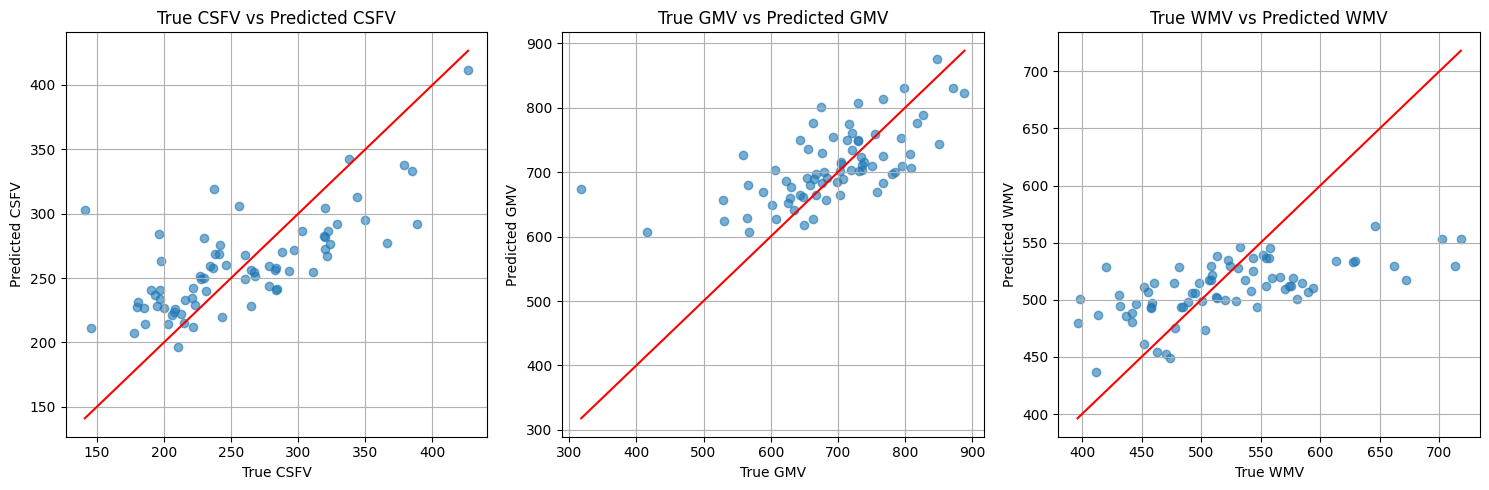

In [207]:
print("VALIDATION PERFORMANCE")
visualize_preds(vol_val_loader, vol_model)

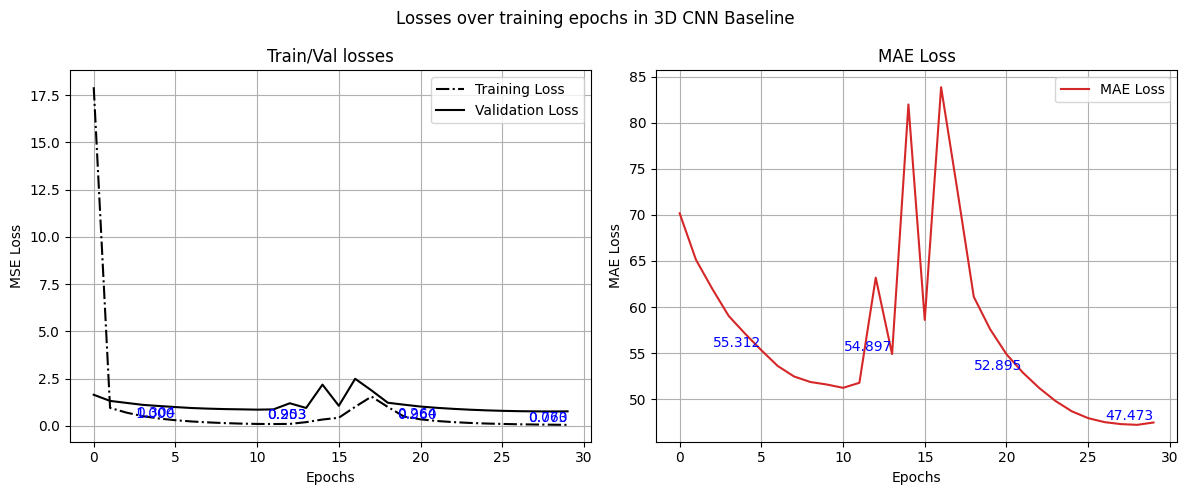

In [208]:
### Plotting Losses

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x_epochs = [i for i in range(epochs)]
ax1.plot(x_epochs, train_losses, 'k', label='Training Loss', linestyle='-.')
ax1.plot(x_epochs, val_losses, 'k', label='Validation Loss')
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Train/Val losses')
# ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y')
ax1.legend()
ax1.grid(True)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('MAE Loss')
ax2.plot(x_epochs, val_mae_losses, color=color, label="MAE Loss")
ax2.tick_params(axis='y')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_title('MAE Loss')
plt.xlabel('Epochs')
fig.suptitle('Losses over training epochs in 3D CNN Baseline')
ax2.grid(True)


for i in range(5, epochs, 8):
    ax1.text(x_epochs[i], train_losses[i], f'{train_losses[i]:.3f}', ha='right', va='bottom', color='b')
    ax1.text(x_epochs[i], val_losses[i], f'{val_losses[i]:.3f}', ha='right', va='top', color='b')
    ax2.text(x_epochs[i], val_mae_losses[i], f'{val_mae_losses[i]:.3f}', ha='right', va='bottom', color='b')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Baseline: Combine models to attain end-to-end predictions

Finally, we will combine the deep learning volume prediction model with the MLP regression model to obtain end-to-end predictions of age from MRI images.

Define the end-to-end validation dataset and data loaders:

In [122]:
class EndToEndDataset(Dataset):

    def __init__(
        self,
        patient_list:List[str],
        mri_file_dir:str,
        meta_df:pd.DataFrame,
        ages_norm_stats:Dict[str,np.array],
        out_spacing = OUT_SPACING,
        out_size = OUT_SIZE,
    ):
        self.samples:List[Dict[str,torch.tensor]] = []

        for pat in tqdm(patient_list, desc='Loading Data'):

            # MRI images
            X = load_patient_mri_array(pat, mri_dir=mri_file_dir).squeeze()
            X = zero_mean_unit_var(X)
            if (out_spacing is not None) and (out_size is not None):
                X = resample_image(X, out_spacing=out_spacing, out_size=out_size)
            X = torch.from_numpy(X).unsqueeze(0).float()

            # Ages
            y = meta_df[meta_df["participant_id"] == pat][["age"]].values.squeeze()
            y = (y-ages_norm_stats['mean'])/ages_norm_stats['std']
            y = torch.tensor(y).unsqueeze(0).float()

            sample = {'X': X,  "y":y}
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return self.samples[item]

In [123]:
e2e_val_data = EndToEndDataset(
    patient_list=val_pats,
    mri_file_dir=TRAIN_MRI_DIR,
    meta_df=train_meta_df,
    ages_norm_stats=age_norm_stats,
)

e2e_val_loader = DataLoader(e2e_val_data, batch_size=2)

tmp = next(e2e_val_loader.__iter__())
print(f"Dataloader has output type {type(tmp)} with keys {tmp.keys()}")
print(f"The input dimensions are: {tmp['X'].shape}")
print(f"The output dimensions are: {tmp['y'].shape}")

Loading Data: 100%|██████████| 74/74 [01:00<00:00,  1.22it/s]

Dataloader has output type <class 'dict'> with keys dict_keys(['X', 'y'])
The input dimensions are: torch.Size([2, 1, 96, 96, 96])
The output dimensions are: torch.Size([2, 1])


Define the combined model:

In [209]:
class CombinedModel(nn.Module):
    def __init__(self, volume_predictor, age_regressor):
        super(CombinedModel, self).__init__()
        self.volume_predictor = volume_predictor
        self.age_regressor = age_regressor

    def forward(self, x):
        x = self.volume_predictor(x)
        return self.age_regressor(x)

In [210]:
combined_model = CombinedModel(vol_model, mlp_model).float().to(device)

tmp = next(e2e_val_loader.__iter__())
output = combined_model(tmp['X'].to(device))

Assess performance of end-to-end model on the validation data:

In [211]:
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model, e2e_loss_fn, age_norm_stats)

Validation loss:  1.227632, MAE:  9.668771



(1.2276322645358615, 9.668770583900246)

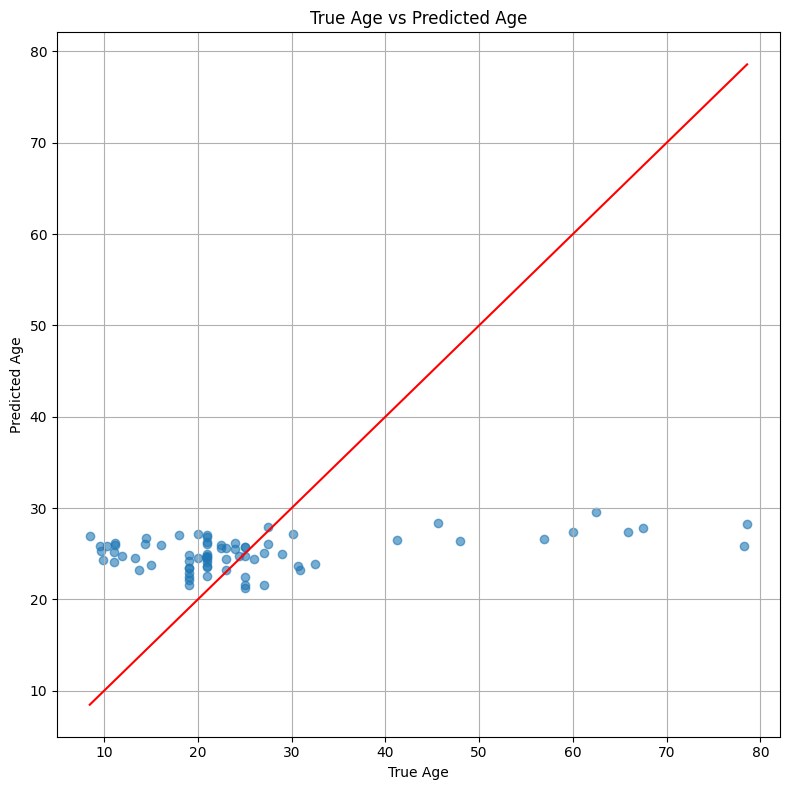

In [212]:
true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches of the validation data (e.g., 10 batches in this example)
for i, batch in enumerate(e2e_val_loader):
    with torch.no_grad():
        inputs = batch['X'].to(device)
        true_ages = batch['y'].cpu().numpy().reshape(-1)
        predicted_ages = combined_model(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# denormalize the true ages
true_ages_list = np.array(true_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']
predicted_ages_list = np.array(predicted_ages_list) * age_norm_stats['std'] + age_norm_stats['mean']

plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title('True Age vs Predicted Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()

#### 🚧 **Exercise 2.2** 🚧

Analyse you results and consider writting about the following in your report:

- Justification for your volume prediction model structure/design
- Discussion of results from volume prediction model
- Discussion of results from the MLP regression model
- Discusion of results from end-to-end combined model
- Discussion of reasonability of performance (and what the limitations may be and why)

You should provide evidence to backup your discussions and any conclusions. This may include showing performance on held out validation/test sets (using the metrics you chose previously), and other statistical tests or visualisations. You do not have to limit yourself to the visualisations/analysis already implemented in the notebook!

<Insert report here>

## Part 3: Improving upon the Baseline

Here you should make three meaningful attempts to improve upon the baseline model.

Start by analysing the performance of the baseline model and propose a hypothesis for where the model could be improved. The hypothesis could align to one of:
* Architecture: Would a different NN architecture be better? Maybe try training a deep learning model end to end, rather than first predicting volumes then predicting age.
* Hyperparameters: Is the learning rate set correctly? Should early stopping or other kinds of regularizations be used?
* Auxiliary losses: Can you use the extra information in the training data to provide richer training signals to the model?
* Data augmentation: Can simple augmentations improve performance? (This can be especially helpful when the dataset is small!)
* Skewed dataset: Are there techniques that can be used to account for the negative effects of a skewed/imbalanced dataset?

Now implement a new model based on your hypothesis!

Iterate though this procedure until you have proposed 3 hypotheses and developed 3 models.

Don’t worry if an experiment does not produce the intended results - write about why you think it didn’t produce those results! Note, that since this is deep learning, there may not always be an obvious explanation - in these cases so long as your initial hypothesis was valid and you have made attempts to find an explanation (where possible) you will not lose marks.

If you feel a set of experiments are leading you down a dead end - don’t worry! Write about why you feel that line of enquiry is not working, take a few steps back (even if that means going back to the baseline model) and start again for your next hypothesis. Failed experiments often yield interesting and insightful results!

**Further guidelines for the hypotheses:**

* Scope: Ensure your hypothesis is not too limited in scope. For example, simply changing the learning rate value once would be insufficient. Instead, you could try a sweep over learning rates.
* Grounded reasoning: Your reasoning and justifications should be grounded in what you have learned in the course materials/lectures/tutorials.
* Evidence-backed conclusions: If you are making conclusions, ensure to present suitably strong evidence. If there is not enough evidence to make a strong conclusion, ensure you acknowledge this.

**Marking:**

In the report, marks will primarily be awarded for:
- The quality of your hypotheses, and their justifications (including how you move from one hypothesis/experiment to the next)
- The quality/thoroughness of the experiments you run to test your hypotheses, and your presentation and discussion of the results

You will __not__ be marked on the overall performance of your model. This coursework is designed to test your ability to propose reasonable experiments and to test your understanding of the content of the course.

## 🚧 Exercise 3.1: Hypothesis 1 🚧

When detailing your Hypothesis 1-3 in the report, some points to touch on include:

- Explain your hypothesis and the reasoning behind it (e.g. why do you think this could improve performance, how does it relate to your previous experiment).
- How do you intend to test the hypothesis (i.e. what experiments will you run)?
- What evidence is required to confirm/disprove the hypothesis?
- What do you hope to learn from your experiments?

### H1: Larger 3D CNN will perform better than the baseline

In [128]:
########################################
# Test Hypothesis 1: INSERT CODE HERE
#
# Feel free to use as many cells as necessary
########################################


class Large3DCNN(nn.Module):
    def __init__(self, in_shape, out_size):
        super(Large3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 2, kernel_size=3)
        self.conv2 = nn.Conv3d(2, 16, kernel_size=3)
        self.conv3 = nn.Conv3d(16, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 10 * 10 * 10, 16)
        self.fc2 = nn.Linear(16, out_size)  # 3 output values: "csfv", "gmv", "wmv"
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        # x = self.pool(self.relu(self.conv4(x)))
        x = torch.flatten(x, start_dim=1)
        # x = x.view(-1, 65536)  # Flatten the input for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [129]:
larger_vol_model = Large3DCNN(in_shape, out_size).float().to(device)
summary(larger_vol_model, (1, 96, 96, 96))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 2, 94, 94, 94]              56
              ReLU-2        [-1, 2, 94, 94, 94]               0
         MaxPool3d-3        [-1, 2, 47, 47, 47]               0
            Conv3d-4       [-1, 16, 45, 45, 45]             880
              ReLU-5       [-1, 16, 45, 45, 45]               0
         MaxPool3d-6       [-1, 16, 22, 22, 22]               0
            Conv3d-7       [-1, 64, 20, 20, 20]          27,712
              ReLU-8       [-1, 64, 20, 20, 20]               0
         MaxPool3d-9       [-1, 64, 10, 10, 10]               0
           Linear-10                   [-1, 16]       1,024,016
             ReLU-11                   [-1, 16]               0
           Linear-12                    [-1, 3]              51
Total params: 1,052,715
Trainable params: 1,052,715
Non-trainable params: 0
---------------------------

In [130]:
tmp = next(vol_train_loader.__iter__())
in_shape = tmp['X'].shape[1:]
out_size = tmp['y'].shape[-1]
input = tmp['X'].to(device)
output = larger_vol_model(input)
print(input.shape, output.shape)

torch.Size([8, 1, 96, 96, 96]) torch.Size([8, 3])


In [131]:
larger_vol_model = Large3DCNN(in_shape, out_size).float().to(device)
vol_loss_fn = nn.MSELoss()
larger_vol_optimizer = torch.optim.Adam(larger_vol_model.parameters(), lr=1e-3)

epochs = 30
train_losses = []
val_losses = []
val_mae_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(vol_train_loader, larger_vol_model, vol_loss_fn, larger_vol_optimizer)
    val_loss, val_mae_loss = test(vol_val_loader, larger_vol_model, vol_loss_fn, volume_norm_stats)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae_loss)
print("Done!")

Epoch 1
-------------------------------
Train loss:  1.151002
Validation loss:  1.371164, MAE: 64.731762

Epoch 2
-------------------------------
Train loss:  0.978097
Validation loss:  1.368610, MAE: 64.701342

Epoch 3
-------------------------------
Train loss:  0.976120
Validation loss:  1.366456, MAE: 64.673292

Epoch 4
-------------------------------
Train loss:  0.974487
Validation loss:  1.364634, MAE: 64.647488

Epoch 5
-------------------------------
Train loss:  0.973145
Validation loss:  1.363097, MAE: 64.625559

Epoch 6
-------------------------------
Train loss:  0.972043
Validation loss:  1.361802, MAE: 64.609083

Epoch 7
-------------------------------
Train loss:  0.971140
Validation loss:  1.360710, MAE: 64.594443

Epoch 8
-------------------------------
Train loss:  0.970399
Validation loss:  1.359790, MAE: 64.585495

Epoch 9
-------------------------------
Train loss:  0.969791
Validation loss:  1.359012, MAE: 64.582043

Epoch 10
-------------------------------
Train

In [134]:
save_model = False
if save_model:
  torch.save(larger_vol_model.state_dict(),'larger_3d_cnn_%d.pth' % epochs) # no need to rerun again

checkpoint_load = False
if checkpoint_load:
  checkpoint = torch.load('/content/drive/MyDrive/dataset_mri/larger_3d_cnn_30.pth',
                          map_location=device)
  larger_vol_model.load_state_dict(checkpoint)


In [135]:
combined_model_h1 = CombinedModel(larger_vol_model, mlp_model).float().to(device)
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model_h1, e2e_loss_fn, age_norm_stats)


Validation loss:  1.345615, MAE:  9.789139



(1.345614918860028, 9.789138781057822)

When discussing the results of your hypothesis 1-3 experiments, some points to touch on include:

- Are the results as expected?
- How strong are the conclusions you can draw, based on the evidence you have collected?
- Any interesting findings or potential interesting followup experiments.

## 🚧 Exercise 3.2: Hypothesis 2 🚧

### Simple kernel ridge regressor can be better than MLP

In [213]:
##########################################
# Test Hypothesis 2: INSERT CODE HERE
##########################################
from sklearn.kernel_ridge import KernelRidge

def to_matrix(data:AgeRegressionDataset, feature:str):
  return torch.stack([d[feature] for d in data.samples])

class CustomKRR:
    def __init__(self, alpha=0.01, gamma=0.1, kernel='rbf'):
      self.krr = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)

    def fit(self, X, y):
      self.krr.fit(X, y)

    def __call__(self, X):
      X_numpy = X.detach().cpu().numpy()
      pred = self.krr.predict(X_numpy)
      return torch.from_numpy(pred).to(X.device)


In [214]:
mlp_train_data.samples#[0]['X']
X_stacked = to_matrix(mlp_train_data, 'X' )
y_stacked = to_matrix(mlp_train_data, 'y')
X_val_stacked = to_matrix(mlp_val_data, 'X')
y_val_stacked = to_matrix(mlp_val_data, 'y')

kernel_ridge = CustomKRR()
kernel_ridge.fit(X_stacked, y_stacked)

In [215]:
### evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# TRAINING
train_pred_y = kernel_ridge(X_stacked)
val_pred_y = kernel_ridge(X_val_stacked)
loss_train_kernel = mean_squared_error(train_pred_y, y_stacked)

# VALIDATION
loss_validation_kernel = mean_squared_error(val_pred_y, y_val_stacked)
mae_loss_valid_kernel = mean_absolute_error(val_pred_y, y_val_stacked)


print(f"Train MSE loss: {loss_train_kernel:9f}")
print(f"Validation MSE loss: {loss_validation_kernel:9f}")
print(f"Validation MAE loss: {mae_loss_valid_kernel:9f}")

Train MSE loss:  0.199173
Validation MSE loss:  0.789170
Validation MAE loss:  0.477077


In [ ]:
# Epoch 30
# -------------------------------
# Train loss:  0.428825
# Validation loss:  0.669866, MAE:  7.467793

In [216]:
combined_model_h2 = CombinedModel(vol_model, kernel_ridge).float().to(device)
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model_h2, e2e_loss_fn, age_norm_stats)

Validation loss:  0.838970, MAE:  7.304453



(0.8389695780729322, 7.304452909005655)

In [ ]:
# MLP: Validation loss:  1.411253, MAE:  9.303493 # recording results
# Baseline 3D CNN + MLP (val loss: 1.28, MAE loss: 9.56)

## 🚧 Exercise 3.3: Hypothesis 3 🚧

### Hyperparameter tuning through bayesian optimization, applied only to the age regressor because of constrained computational resources

In [223]:
##########################################
# Test Hypothesis 3: INSERT CODE HERE
##########################################
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the hyperparameter search space
search_spaces = {
    'alpha': Real(1e-3, 5e-1, prior='log-uniform'),
    'gamma': Real(1e-3, 2, prior='log-uniform')
}

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = X_stacked, X_val_stacked, y_stacked, y_val_stacked

# Initialize the Kernel Ridge Regression model

class MyKernelRidge(KernelRidge):
    def __call__(self, X):
        X_numpy = X.detach().cpu().numpy()
        pred = self.predict(X_numpy)
        return torch.from_numpy(pred).to(X.device)
krr = MyKernelRidge()
# Perform Bayesian optimization for hyperparameter tuning
opt = BayesSearchCV(
    krr,
    search_spaces,
    n_iter=10,
    cv=5
)

# Fit the optimizer to the training data
opt.fit(X_train, y_train)

# Evaluate the best model on the validation set
best_model = opt.best_estimator_
val_score = best_model.score(X_val, y_val)
print("Validation score of the best model:", val_score)
best_model.get_params

Validation score of the best model: 0.5854085246447708


<bound method BaseEstimator.get_params of MyKernelRidge(alpha=0.0013881630245550043, gamma=0.018127379223833385)>

In [218]:
# TRAINING
train_pred_y = best_model(X_stacked)
val_pred_y = best_model(X_val_stacked)
loss_train_kernel = mean_squared_error(train_pred_y, y_stacked)

# VALIDATION
loss_validation_kernel = mean_squared_error(val_pred_y, y_val_stacked)
mae_loss_valid_kernel = mean_absolute_error(val_pred_y, y_val_stacked)


print(f"Train MSE loss: {loss_train_kernel:9f}")
print(f"Validation MSE loss: {loss_validation_kernel:9f}")
print(f"Validation MAE loss: {mae_loss_valid_kernel:9f}")

Train MSE loss:  0.466202
Validation MSE loss:  0.554297
Validation MAE loss:  0.494506


In [219]:
combined_model_h3 = CombinedModel(vol_model, best_model).float().to(device)
e2e_loss_fn = nn.MSELoss()
test(e2e_val_loader, combined_model_h3, e2e_loss_fn, age_norm_stats)

Validation loss:  0.847327, MAE:  7.703134



(0.8473267295976749, 7.703133840818663)

In [195]:
# Not enough computational resources
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
# Define the hyperparameter search space
import gc
@use_named_args([Real(1e-4, 5e-1, name='learning_rate')])

# Create a hyperparameter optimization loop
def run_model(learning_rate):
    # Create a new model with the given learning rate
    vol_model = VolumePredictor(in_shape, out_size).float().to(device)
    vol_loss_fn = nn.MSELoss()
    vol_optimizer = torch.optim.Adam(vol_model.parameters(), lr=learning_rate)
    
    counter = 0
    # Train and validate the model
    for t in range(30):
        print("Epoch: ", t)
        train_loss = train(vol_train_loader, vol_model, vol_loss_fn, vol_optimizer)
        val_loss, val_mae_loss = test(vol_val_loader, vol_model, vol_loss_fn, volume_norm_stats)
        counter += val_mae_loss
    # pdb.set_trace()
    counter /= 30
    torch.cuda.empty_cache()
    gc.collect()
    return counter
# Run the hyperparameter optimization loop
search_space = [Real(1e-4, 5e-1, name='learning_rate')]
# Run the Bayesian optimization process
# result = gp_minimize(run_model, search_space, n_calls=10)

## 🚧 Exercise 3.4: Concluding Discussion 🚧

Now you should have trained and validated 4 models (the baseline, and your 3 hypotheses). Below, you should do a final comparison of performances of the models **using the test data!**. This should be the **first and only time** you use the test data!

In your report, you should discuss potential reasons for differences in performance between all 4 models, and conclude which model is best (if any)

In [201]:
################################################
# INSERT CODE HERE
################################################
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

test_age_norm_stats = {
    'mean': test_meta_df["age"].mean(axis=0),
    'std': test_meta_df["age"].std(axis=0)
}

e2e_test_data = EndToEndDataset(
    patient_list=test_pats,
    mri_file_dir=TEST_MRI_DIR,
    meta_df=test_meta_df,
    ages_norm_stats=test_age_norm_stats,
)
e2e_test_loader = DataLoader(e2e_test_data, batch_size=2)



Loading Data: 100%|██████████| 167/167 [02:09<00:00,  1.29it/s]


In [224]:
print("Test set metrics: ")
print("Baseline: 3D CNN + MLP ")
test(e2e_test_loader, combined_model, test_metric, test_age_norm_stats)
print("H1: Larger 3D CNN + MLP")
test(e2e_test_loader, combined_model_h1, test_metric, test_age_norm_stats)
print("H2: 3D CNN + kernel ridge regressor")
test(e2e_test_loader, combined_model_h2, test_metric, test_age_norm_stats)
print("H3: 3D CNN + hparam optimization of kernel ridge regressor ")
test(e2e_test_loader, combined_model_h3, test_metric, test_age_norm_stats)

Test set metrics: 
Baseline: 3D CNN + MLP 
Validation loss:  0.630185, MAE:  7.198770

H1: Larger 3D CNN + MLP
Validation loss:  0.624337, MAE:  7.131959

H2: 3D CNN + kernel ridge regressor
Validation loss:  0.598969, MAE:  6.842181

H3: 3D CNN + hparam optimization of kernel ridge regressor 
Validation loss:  0.632278, MAE:  7.222672



(0.6322777674843868, 7.222671877770197)

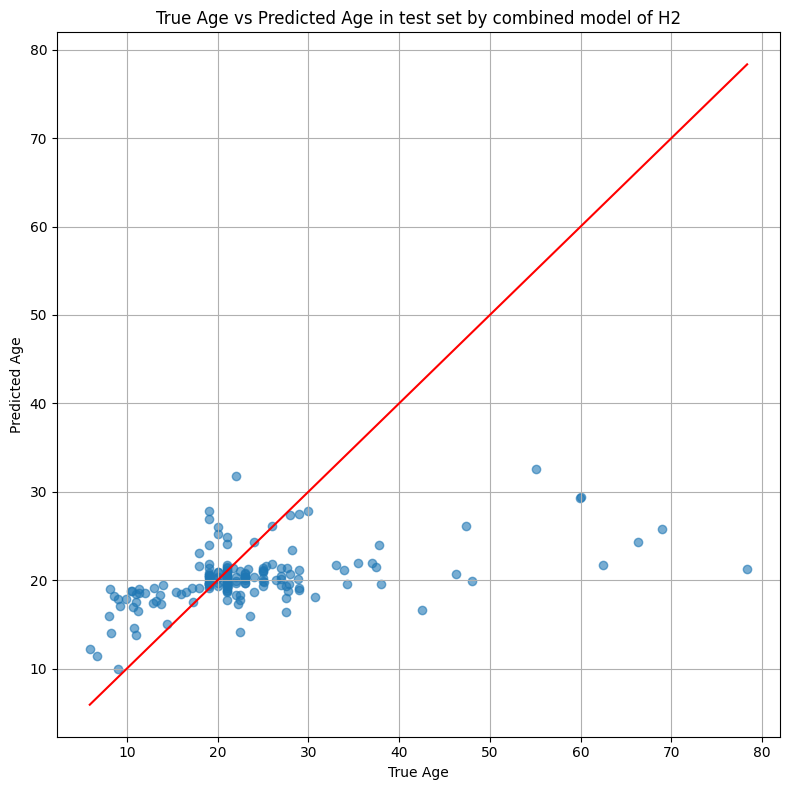

In [222]:
true_ages_list = []
predicted_ages_list = []

# Loop through the loader for a certain number of batches of the validation data (e.g., 10 batches in this example)
for i, batch in enumerate(e2e_test_loader):
    with torch.no_grad():
        inputs = batch['X'].to(device)
        true_ages = batch['y'].cpu().numpy().reshape(-1)
        predicted_ages = combined_model_h2(inputs).detach().cpu().numpy().reshape(-1)
    true_ages_list.extend(true_ages)
    predicted_ages_list.extend(predicted_ages)

# denormalize the true ages
true_ages_list = np.array(true_ages_list) * test_age_norm_stats['std'] + test_age_norm_stats['mean']
predicted_ages_list = np.array(predicted_ages_list) * test_age_norm_stats['std'] + test_age_norm_stats['mean']

plt.figure(figsize=(8, 8))
plt.scatter(true_ages_list, predicted_ages_list, alpha=0.6)
plt.title('True Age vs Predicted Age in test set by combined model of H2')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.plot([min(true_ages_list), max(true_ages_list)], [min(true_ages_list), max(true_ages_list)], color='red')  # Line of best fit
plt.grid(True)
plt.tight_layout()
plt.show()